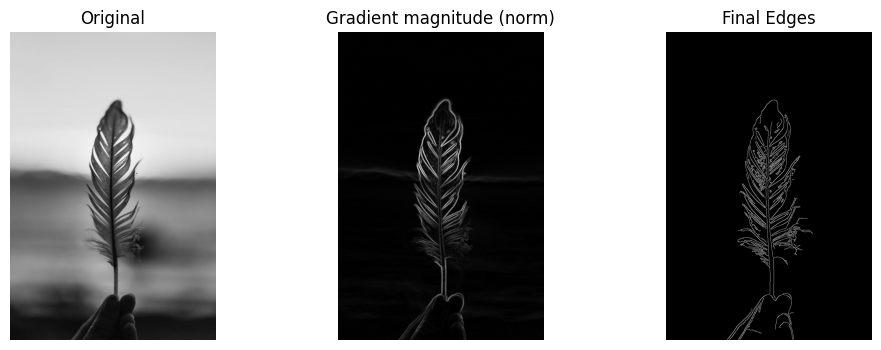

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- load image as float32 grayscale ---
image = cv2.imread(r"input.jpg", cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError("Image not found, check path.")
image = image.astype(np.float32)

# --- gaussian kernel ---
def gaussian_kernel(size=5, sigma=1.4):
    k = size // 2
    xs = np.arange(-k, k+1, dtype=np.float32)
    xx, yy = np.meshgrid(xs, xs)
    g = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    return g / np.sum(g)

# --- convolution with reflect padding (same output shape) ---
def convolve(img, kernel):
    kh, kw = kernel.shape
    pad_h = kh // 2
    pad_w = kw // 2
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    out = np.zeros_like(img, dtype=np.float32)
    # naive loops (easy to understand)
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            region = padded[i:i+kh, j:j+kw]
            out[i, j] = np.sum(region * kernel)
    return out

# --- Sobel kernels ---
Sx = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]], dtype=np.float32)
Sy = np.array([[1, 2, 1],
               [0, 0, 0],
               [-1, -2, -1]], dtype=np.float32)

# --- pipeline ---
gauss = gaussian_kernel(5, 1.4)
blurred = convolve(image, gauss)

Gx = convolve(blurred, Sx)
Gy = convolve(blurred, Sy)

magnitude = np.hypot(Gx, Gy)  # float
angle = np.arctan2(Gy, Gx)    # radians

# normalize magnitude to 0-255 for thresholding & visualization
mag_norm = (magnitude - magnitude.min())
if mag_norm.max() > 0:
    mag_norm = (mag_norm / mag_norm.max()) * 255.0
else:
    mag_norm = mag_norm

# --- non-maximum suppression ---
def non_max_suppression(mag, ang):
    H, W = mag.shape
    out = np.zeros((H, W), dtype=np.float32)
    angle_deg = np.degrees(ang) % 180.0

    for i in range(1, H-1):
        for j in range(1, W-1):
            a = angle_deg[i, j]

            # default neighbours
            q = 0.0
            r = 0.0

            # 0 deg
            if (0 <= a < 22.5) or (157.5 <= a < 180):
                q = mag[i, j+1]
                r = mag[i, j-1]
            # 45 deg
            elif (22.5 <= a < 67.5):
                q = mag[i+1, j-1]
                r = mag[i-1, j+1]
            # 90 deg
            elif (67.5 <= a < 112.5):
                q = mag[i+1, j]
                r = mag[i-1, j]
            # 135 deg
            elif (112.5 <= a < 157.5):
                q = mag[i-1, j-1]
                r = mag[i+1, j+1]

            if (mag[i, j] >= q) and (mag[i, j] >= r):
                out[i, j] = mag[i, j]
            else:
                out[i, j] = 0.0
    return out

nms = non_max_suppression(mag_norm, angle)

# --- double threshold: using ratios (safer across images) ---
low_ratio = 0.05   # weak threshold = 5% of max
high_ratio = 0.15  # strong threshold = 15% of max
high = nms.max() * high_ratio
low = high * low_ratio  # note: you can also pick low = nms.max() * low_ratio

strong = 255
weak = 50

edges = np.zeros_like(nms, dtype=np.uint8)
strong_i, strong_j = np.where(nms >= high)
weak_i, weak_j = np.where((nms >= low) & (nms < high))

edges[strong_i, strong_j] = strong
edges[weak_i, weak_j] = weak

# --- hysteresis: use DFS/BFS from strong pixels to capture chains ---
def hysteresis(img, weak=50, strong=255):
    H, W = img.shape
    out = img.copy().astype(np.uint8)

    # stack of strong coordinates to start from
    strong_coords = list(zip(*np.where(out == strong)))

    # 8-connected neighbors relative positions
    neighbor_offsets = [(-1, -1), (-1, 0), (-1, 1),
                        (0, -1),           (0, 1),
                        (1, -1),  (1, 0),  (1, 1)]

    while strong_coords:
        i, j = strong_coords.pop()
        for di, dj in neighbor_offsets:
            ni, nj = i + di, j + dj
            if ni < 0 or ni >= H or nj < 0 or nj >= W:
                continue
            if out[ni, nj] == weak:
                # promote weak to strong and add to stack to propagate
                out[ni, nj] = strong
                strong_coords.append((ni, nj))

    # any remaining weak -> zero
    out[out != strong] = 0
    return out

final_edges = hysteresis(edges, weak=weak, strong=strong)

# --- save / show results ---
# cv2.imwrite("edges_output.png", final_edges)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Original"); plt.axis('off'); plt.imshow(image, cmap='gray')
plt.subplot(1,3,2); plt.title("Gradient magnitude (norm)"); plt.axis('off'); plt.imshow(mag_norm, cmap='gray')
plt.subplot(1,3,3); plt.title("Final Edges"); plt.axis('off'); plt.imshow(final_edges, cmap='gray')
plt.show()
